In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from helpers import *
%load_ext autoreload
%autoreload 2

In [2]:
data_path = 'train.csv'
y_raw, x_raw, ids = load_csv_data(data_path, True)

# Math functions

In [163]:
f_mse = lambda y,x,w, reg: 1/(2*len(y))*LA.norm(y-x.dot(w))**2 + reg*LA.norm(w)**2
gradf_mse = lambda y,x,w, reg: -1/len(y)*x.T.dot(y-x.dot(w)) + 2*reg*w
sigmoid = lambda x: 1./(1.+np.exp(-x))
f_logistic = lambda y,x,w, reg: -np.sum(np.log(sigmoid(y*np.dot(x,w))), axis=0)/len(y) + reg*LA.norm(w)**2
gradf_logistic = lambda y,x,w, reg: (-x.T.dot((1. - sigmoid(y*(x.dot(w)))) * y))/len(y) + 2*reg*w

# functions 

In [164]:
def clean(x):
    '''replace -999 by mean of the rest'''
    for i in range(len(x[0])):
        tmp = x[:,i]
        tmp[tmp == -999] = np.mean(tmp[tmp != -999])
        x[:,i] = tmp
    return x

In [165]:
def std(x, mean, stdv):
    for i in range(1, len(x[0])):
        x[:,i] = (x[:,i] - mean[i])/stdv[i]
    return x

In [166]:
def addcolumn(x,f):
    for i in range(len(f)):
        for j in range(d):
            x = np.concatenate((x, f[i](x[:,j]).reshape(-1,1)), axis = 1)
    x = np.concatenate((np.ones((len(x[:,0]),1)), x), axis = 1)
    return x

In [167]:
def preprocess(y_in, x_in, mask, f):
    '''apply mask --> clean --> std --> for each parameter x[:,i] and each f[j], add 1 column f[j](x[:,i]) 
    --> add column "1" to the left'''
    x = clean(x_in[:, mask])
    yx = np.concatenate((y_in, x), axis = 1)
    np.random.shuffle(yx)
    y = yx[:,0]
    x = yx[:,1:]
    x = addcolumn(x,f)
    return y, x

In [168]:
def split(y, x):
    '''reshape x_in, y_in into K subsets of size (N//K) x d'''
    return y.reshape(K, N//K, 1).copy(), x.reshape(K, N//K, D).copy()

In [169]:
def get_train_test(y_in, x_in, k, train_more):
    #define a mask to filter out the k-th element 
    no_k = np.ones(K, dtype = bool)
    no_k[k] = False
    
    x = x_in[k].copy()
    y = y_in[k].copy()
    x_rest = x_in[no_k].reshape(N - N//K, D).copy()
    y_rest = y_in[no_k].reshape(N-N//K, 1).copy()
    m = np.mean(x, axis = 0)
    m_rest = np.mean(x_rest, axis = 0)
    s = np.std(x, axis = 0)
    s_rest = np.std(x_rest, axis = 0)
    #print(np.max(abs(m_rest-m)))
    #print(np.max(abs(s_rest-s)))
    if train_more == True:
        mean = m_rest
        stdv = s_rest
        return y_rest, y, std(x_rest, mean, stdv), std(x, mean, stdv), mean, stdv
    else:
        mean = m
        stdv = s
        return y, y_rest, std(x, mean, stdv), std(x_rest, mean, stdv), mean, stdv

In [170]:
def get_stsize(y, x, w, f, gradf, reg):
    sts = 1/(0.0000005*np.max(np.linalg.eig(x.T.dot(x))[0]))
    a = gradf(y, x, w, reg)
    b = f(y, x, w, reg)
    c = LA.norm(gradf(y, x, w, reg))**2
    while f(y, x, w - sts*a, reg) > b - sts/2*c:
        sts = sts * beta
        #if sts < 1/(1*np.max(np.linalg.eig(x.T.dot(x))[0])): return sts
        #print(sts)
    #print('\n')
    return sts

In [226]:
def GD(y, x, w0, st_size, f, gradf, reg):
    w = np.zeros((n_iter+1,D,1))
    L = np.zeros(n_iter+1)
    w[0] = w0
    L[0] = f(y,x,w[0], reg)
    for i in range(n_iter):
        st_size = get_stsize(y,x,w[i], f, gradf, reg)
        w[i+1] = w[i] - st_size*gradf(y, x, w[i], reg)
        L[i+1] = f(y,x,w[i], reg)
    return w, L

In [172]:
def SGD(y, x, w0, st_size, f, gradf, reg):
    w = np.zeros((n_iter+1, D,1))
    L = np.zeros(n_iter+1)
    w[0] = w0
    window = np.random.randint(0, len(y), size=1)
    L[0] = f(y[window],x[window],w[0], reg)
    #st_size = 1/(np.max(np.linalg.eig(x.T.dot(x))[0]))
    for i in range(n_iter):
        #define filter
        window = np.random.randint(0, len(y), size=1)
        #line search st size
        #st_size = get_stsize(y[window],x[window],w[i], f, gradf) adaptive stepsize is not useful for SGD
        w[i+1] = w[i] - st_size*gradf(y[window], x[window], w[i], reg)
        L[i+1] = f(y[window],x[window],w[i], reg)
        #if i%10 == 0: st_size /= 2 
    return w, L

In [173]:
def mse_normal(y,x,w0,st_size,f,gradf, reg):
    w = np.ones((n_iter+1, D,1)) * LA.inv(x.T.dot(x)+reg*2*len(y)*np.eye(D)).dot(x.T.dot(y)) 
    L = np.ones(n_iter+1) * f(y, x, w[n_iter], reg)
    return w,L

In [174]:
def train(mod, alg, y, x, w0, reg):
    f, gradf, st_size = model_train[mod]
    return alg(y, x, w0, st_size, f, gradf, reg)


# Initialization

In [197]:
#set mask to filter out parameters that wont be used
mask = np.ones(len(x_raw[0]), dtype=bool)
mark = [] #np.array([0,4,5,6,9,11,12,15,18,20,23,24,25,26,27,28,29]) #############
mask [mark] = False
#set model functions (Ex: higher order regression,...)
model_func = []#lambda x: x**2,
              #lambda x: x**3]#,
              #lambda x: x**5]


d = np.sum(mask) #number of original parameter used
N = len(y_raw)
K = 5 #K>=2
print('d=', d)

d= 30


In [198]:
x_raw = x_raw.reshape(N, 30)
y_raw = y_raw.reshape(N, 1)
y_full, x_full = preprocess(y_raw, x_raw, mask, model_func)
D = len(x_full[0]) #number of total parameter
print('D=', D)

D= 31


In [199]:
ys, xs = split(y_full.copy(), x_full.copy())

In [227]:
n_iter = 500
beta = 0.5 #parameter to reduce stepsize in backtracking line search st=st*beta
train_more = True #choose to train by K-1 or 1 data set and test on the rest
reg = 0 #10**(-4.3)
w0 = np.zeros((D,1))
#set training model (EX: logistic, mse,...)
model_train = {'logistic':(f_logistic, gradf_logistic, 0.001), #0.05 for GD of subsample, 0.001 for SGD subsample
               'mse':(f_mse, gradf_mse, 0.0002) # 0.01 for GD subsample, 0.0002 for SGD subsampple
               } 


In [228]:
#test
#y, yt, x, xt = get_train_test(ys, xs, 0, train_more)
#print(np.std(x,axis =0))
# stst = 1/(0.0000005*np.max(np.linalg.eig(x.T.dot(x))[0]))
# print(stst)
# a = f_logistic(y, x, w0 - stst*gradf_logistic(y, x, w0))
# b = f_logistic(y, x, w0)
# c = LA.norm(gradf_logistic(y, x, w0))**2
# print(a>b-stst/2*c)


# Main

In [229]:
def main(K, reg, mod, alg, ys, xs, train_more, w0):
    E = np.zeros((K, D))
    STD = np.zeros((K, D))
    wf = np.zeros((K, n_iter+1, D))
    Lf = np.zeros((K, n_iter+1))
    acc = np.zeros((K, n_iter+1))
    for i in range(K):
        #print('running'+ str(i) +'-th batch')
        y, yt, x, xt, E[i], STD[i] = get_train_test(ys, xs, i, train_more)
        tmp_wf, Lf[i] = train(mod, alg, y, x, w0, reg) ##################
        wf[i] = tmp_wf.reshape(n_iter+1,D)
        for j in range(n_iter+1):
            acc[i,j] = np.sum(np.sign(xt.dot(wf[i,j]).reshape(-1,1)) == yt)/len(yt)*100
    #print('done')
    #plt.plot(Lf[0])
    return wf, Lf, acc, E, STD

In [233]:
wf, Lf, acc, E, STD = main(K, reg, 'logistic', GD, ys, xs, train_more, w0)
#acc: else
#acc1: mse GD 5k iter, fixed stsize
#acc2: mse SGD 5k iter
#acc3: logistic GD 5k iter, fixed stsize
#acc4: logistic SGD 5k iter
#acc5: mse, SGD 50k iter 
#acc6: logistic, SGD 50k iter
#acc7: mse, GD 500 iter, adapt stsize
#acc8: logistic, GD 500 iter, adapt stsize
#acc9: logistic, GD 500 iter, adapt stsize, 

75.22
1.31


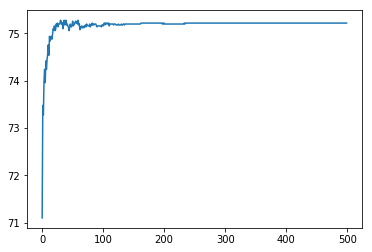

In [234]:
acc8 = acc.copy()
plt.plot(np.mean(acc[:,1:], axis = 0))
print(round(np.mean(acc[:, n_iter]), 2))
print(round(np.std(acc[:, n_iter]), 2))

In [41]:
# loop through many reg para values
reg_arr = np.linspace(-9, -1, 81, endpoint=True)
accf = np.zeros(len(reg_arr))
for ireg in range(len(reg_arr)):
    wf, Lf, acc = main(K, 10**reg_arr[ireg], 'mse', SGD, ys, xs, train_more, w0)
    accf[ireg] = (np.max(np.mean(acc[:, n_iter])))
    

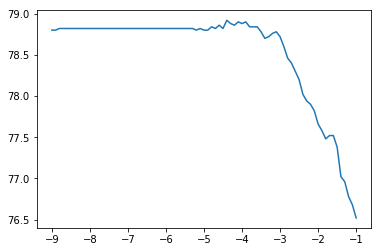

In [50]:
plt.plot(reg_arr, accf)
accf1 = accf
# reg_arr = np.linspace(-9, -1, 81, endpoint=True)
# accf1 mse, mse_normal, 500 iter
# accf2 mse, GD, 500 iter
# accf3 mse, SGD, 5000 iter 
# accf4 logistic, GD 500 iter
# accf5 logistic, SGD 5000 iter
# plot(reg_arr, accf1-5) and put legends

In [67]:
print(round(reg_arr[np.unravel_index(np.argmax(accf, axis=None), accf.shape)], 2))
print(reg_arr)

-4.4
[-9.  -8.9 -8.8 -8.7 -8.6 -8.5 -8.4 -8.3 -8.2 -8.1 -8.  -7.9 -7.8 -7.7
 -7.6 -7.5 -7.4 -7.3 -7.2 -7.1 -7.  -6.9 -6.8 -6.7 -6.6 -6.5 -6.4 -6.3
 -6.2 -6.1 -6.  -5.9 -5.8 -5.7 -5.6 -5.5 -5.4 -5.3 -5.2 -5.1 -5.  -4.9
 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7 -3.6 -3.5
 -3.4 -3.3 -3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3 -2.2 -2.1
 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1. ]


# output

74.97999999999999
1.2639620247459977
75.26
1.2815615474880644


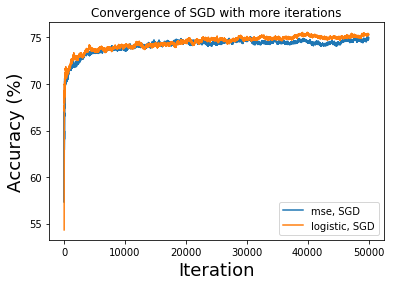

In [225]:
xplot = np.arange(0, n_iter, 1)
y5plot = np.mean(acc5[:,1:], axis = 0)
y6plot = np.mean(acc6[:,1:], axis = 0)
plt.plot(xplot, y5plot, xplot, y6plot)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.legend(('mse, SGD', 'logistic, SGD'), loc = 'lower right')
plt.title('Convergence of SGD with more iterations')
print(np.mean(acc5[:, n_iter]))
print(np.std(acc5[:, n_iter]))
print(np.mean(acc6[:, n_iter]))
print(np.std(acc6[:, n_iter]))

74.97999999999999
1.3257450735341225
75.22
1.310572394032471


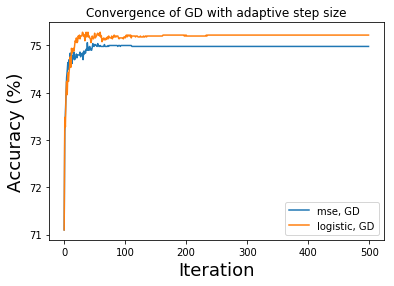

In [235]:
xplot = np.arange(0, n_iter, 1)
y7plot = np.mean(acc7[:,1:], axis = 0)
y8plot = np.mean(acc8[:,1:], axis = 0)
plt.plot(xplot, y7plot, xplot, y8plot)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.legend(('mse, GD', 'logistic, GD'), loc = 'lower right')
plt.title('Convergence of GD with adaptive step size')
print(np.mean(acc7[:, n_iter]))
print(np.std(acc7[:, n_iter]))
print(np.mean(acc8[:, n_iter]))
print(np.std(acc8[:, n_iter]))

75.02
1.3013838787997962
73.82000000000001
1.0851727973000431
75.18
1.399142594591416
73.72
1.524991803256661


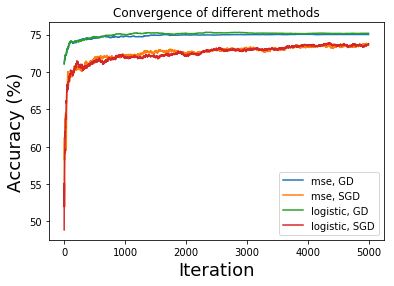

In [217]:
xplot = np.arange(0, n_iter, 1)
y1plot = np.mean(acc1[:,1:], axis = 0)
y2plot = np.mean(acc2[:,1:], axis = 0)
y3plot = np.mean(acc3[:,1:], axis = 0)
y4plot = np.mean(acc4[:,1:], axis = 0)
lines = plt.plot(xplot, y1plot, xplot, y2plot, xplot, y3plot, xplot, y4plot)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.xlabel('Iteration', fontsize=18)
plt.legend(('mse, GD', 'mse, SGD', 'logistic, GD', 'logistic, SGD'), loc = 'lower right')
plt.title('Convergence of different methods')

print(np.mean(acc1[:, n_iter]))
print(np.std(acc1[:, n_iter]))

print(np.mean(acc2[:, n_iter]))
print(np.std(acc2[:, n_iter]))

print(np.mean(acc3[:, n_iter]))
print(np.std(acc3[:, n_iter]))

print(np.mean(acc4[:, n_iter]))
print(np.std(acc4[:, n_iter]))

# run with test.csv

In [193]:
accf = np.mean(acc[:,1:], axis = 0)
i_f = np.unravel_index(np.argmax(acc, axis=None), acc.shape)
print(i_f)
print(acc[i_f])
wff = wf[i_f]
print(wff)

(2, 391)
82.39999999999999
[-1.79725797e+00  2.32327027e+00 -6.41604998e-01  2.92468407e-01
  6.99317917e-01 -2.97573753e-01 -7.57159613e-01 -1.48771322e-01
  2.41103889e+00 -4.38342333e-01  4.30811779e-01 -1.28707983e+00
  1.64277593e-02  1.65654472e-02  1.18992077e+00 -8.34960123e-03
  2.33831852e-01  1.29148977e+00  9.77316485e-02  3.30727740e-01
 -2.85601702e-01 -8.18527507e-02  4.71777295e-01 -1.22569555e-01
  7.64962882e-01 -1.25285238e-01  4.35533677e-02  2.42846280e-01
 -3.04648077e-02 -8.24329184e-02 -1.10098270e-02 -3.14872377e+00
 -6.10593765e-01 -2.94230915e+00 -1.36369290e-01  4.08332190e-01
  4.12595175e-01 -1.08631942e-02 -1.96897639e-01  1.26056021e+00
 -6.70105112e-01  5.00314744e-01  1.76397456e-01  2.10838117e-01
 -1.18890137e+00 -1.51185361e-01 -3.12131495e-02  2.02227261e-01
 -2.17338416e-01  4.74897772e-02  4.71039338e-01  1.78688183e-03
 -1.07555092e+00  3.57894628e-02 -7.53019986e-01  2.79567790e-01
 -5.86609855e-02  9.14851470e-02  2.97010975e-01 -3.68801781e-0

In [155]:
y_test_raw, x_test_raw, ids_test = load_csv_data('test.csv')

In [194]:
n_test = len(y_test_raw)
print(n_test)
x_test = x_test_raw.reshape(n_test, len(x_test_raw[0]))
y_test = y_test_raw.reshape(n_test, 1)
print(x_test.shape)
y_tt, x_tt = preprocess(y_test.copy(), x_test.copy(), mask, model_func)
x_ttt = std(x_tt, E[i_f[0]], STD[i_f[0]])

568238
(568238, 30)


In [195]:
print(wff)
print(np.sum(np.sign(x_tt.dot(wff)) == 1)*100/n_test)

[-1.79725797e+00  2.32327027e+00 -6.41604998e-01  2.92468407e-01
  6.99317917e-01 -2.97573753e-01 -7.57159613e-01 -1.48771322e-01
  2.41103889e+00 -4.38342333e-01  4.30811779e-01 -1.28707983e+00
  1.64277593e-02  1.65654472e-02  1.18992077e+00 -8.34960123e-03
  2.33831852e-01  1.29148977e+00  9.77316485e-02  3.30727740e-01
 -2.85601702e-01 -8.18527507e-02  4.71777295e-01 -1.22569555e-01
  7.64962882e-01 -1.25285238e-01  4.35533677e-02  2.42846280e-01
 -3.04648077e-02 -8.24329184e-02 -1.10098270e-02 -3.14872377e+00
 -6.10593765e-01 -2.94230915e+00 -1.36369290e-01  4.08332190e-01
  4.12595175e-01 -1.08631942e-02 -1.96897639e-01  1.26056021e+00
 -6.70105112e-01  5.00314744e-01  1.76397456e-01  2.10838117e-01
 -1.18890137e+00 -1.51185361e-01 -3.12131495e-02  2.02227261e-01
 -2.17338416e-01  4.74897772e-02  4.71039338e-01  1.78688183e-03
 -1.07555092e+00  3.57894628e-02 -7.53019986e-01  2.79567790e-01
 -5.86609855e-02  9.14851470e-02  2.97010975e-01 -3.68801781e-02
 -6.64326269e-01 -2.18061

In [831]:
create_csv_submission(ids_test, predict_labels(wff,x_tt), 'how_bad_can_it_get.csv')